<a href="https://colab.research.google.com/github/Dhaneshkp/GraphML/blob/main/Fraud_xgb%20-%20Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

!pip install --upgrade certifi

!pip install --trusted-host files.pythonhosted.org optuna



In [2]:
#os.listdir("/kaggle/input/fraud-detection")

In [3]:
data=pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")

In [4]:

def are_cc_numbers_unique(df, cc_column):

    try:
      # Check if the specified column exists in the DataFrame.
      if cc_column not in df.columns:
          print(f"Error: Column '{cc_column}' not found in the DataFrame.")
          return False

      return df[cc_column].nunique() == len(df)

    except Exception as e:
      print(f"An error occurred: {e}")
      return False


are_unique = are_cc_numbers_unique(data, 'cc_num')

if are_unique:
     print("All credit card numbers are unique.")
else:
     print("Some credit card numbers are duplicated.")

Some credit card numbers are duplicated.


In [5]:

import datetime

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Extract the time of day as an integer representing minutes since midnight
data['time_of_day'] = (data['trans_date_trans_time'].dt.hour * 60) + data['trans_date_trans_time'].dt.minute


data['time_of_day_category'] = pd.cut(data['time_of_day'], bins=[0, 6*60, 12*60, 18*60, 24*60],
                                      labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)


data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,time_of_day,time_of_day_category
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Night
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Night
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Night
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1,Night
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,3,Night


In [6]:

data['unix_time_c'] = pd.to_datetime(data['unix_time'], unit='s')

# Extract the time of day as an integer representing minutes since midnight
data['time_of_day_uc'] = (data['unix_time_c'].dt.hour * 60) + data['unix_time_c'].dt.minute

data['time_of_day_category_uc'] = pd.cut(data['time_of_day_uc'], bins=[0, 6*60, 12*60, 18*60, 24*60],
                                      labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,time_of_day,time_of_day_category,unix_time_c,time_of_day_uc,time_of_day_category_uc
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Night,2012-01-01 00:00:18,0,Night
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Night,2012-01-01 00:00:44,0,Night
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Night,2012-01-01 00:00:51,0,Night
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1,Night,2012-01-01 00:01:16,1,Night
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,3,Night,2012-01-01 00:03:06,3,Night


In [7]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'time_of_day',
       'time_of_day_category', 'unix_time_c', 'time_of_day_uc',
       'time_of_day_category_uc'],
      dtype='object')

In [8]:
data.describe()

,Unnamed: 0,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,time_of_day,unix_time_c,time_of_day_uc
count,1.296675e+06,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1296675,1.296675e+06
mean,6.483370e+05,2019-10-03 12:47:28.070214144,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,7.977868e+02,2012-10-03 05:53:56.726123008,7.977868e+02
min,0.000000e+00,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,0.000000e+00,2012-01-01 00:00:18,0.000000e+00
25%,3.241685e+05,2019-06-03 19:12:22.500000,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,4.580000e+02,2012-06-03 19:12:22.500000,4.580000e+02
50%,6.483370e+05,2019-10-03 07:35:47,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,8.480000e+02,2012-10-03 07:35:47,8.480000e+02
75%,9.725055e+05,2020-01-28 15:02:55.500000,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,1.145000e+03,2013-01-28 15:02:55.500000,1.145000e+03
max,1.296674e+06,2020-06-21 12:13:37,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,1.439000e+03,2013-06-21 12:13:37,1.439000e+03
std,3.743180e+05,NaN,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,4.094252e+02,NaN,4.094252e+02


In [9]:
data.describe(include='object')

,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
unique,693,14,352,481,2,983,894,51,494,968,1296675
top,fraud_Kilback LLC,gas_transport,Christopher,Smith,F,864 Reynolds Plains,Birmingham,TX,Film/video editor,1977-03-23,8f7c8e4ab7f25875d753b422917c98c9
freq,4403,131659,26669,28794,709863,3123,5617,94876,9779,5636,1


In [10]:
train_df = data.drop(['Unnamed: 0', 'trans_date_trans_time','trans_num', 'unix_time'],axis=1)


In [11]:
train_df=train_df.sample(frac=0.5,random_state=1)# if the data us indded by a person or a cc num then this sampling isnt appropriate

In [12]:
train_df['distance']= (train_df['lat'] - train_df['merch_lat'])**2 + (train_df['long'] - train_df['merch_long'])**2

In [13]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english') and not word.isdigit()])
    return text

# Apply cleaning to relevant columns
#train_df['merchant'] = train_df['merchant'].apply(clean_text)
#train_df['category'] = train_df['category'].apply(clean_text)
train_df['city_state'] = train_df['city'] + '_' + train_df['state']

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
train_df['city_state'] = train_df['city'] + '_' + train_df['state']

In [15]:
from datetime import datetime

# Function to calculate age
def calculate_age(dob):
    dob = str(dob)
    today = datetime.today()
    dob = datetime.strptime(dob, '%Y-%m-%d')
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column
train_df['age'] = data['dob'].apply(calculate_age)


In [16]:
#train_df = train_df.dropna(subset=['dob'])

In [17]:
categorical_columns = ['category', 'gender', 'job','city','state','merchant','street','city_state']
for column in categorical_columns:
    train_df[column] = train_df[column].astype('category')

In [18]:
train_df.dtypes

cc_num                              int64
merchant                         category
category                         category
amt                               float64
first                              object
last                               object
gender                           category
street                           category
city                             category
state                            category
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                              category
dob                                object
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
time_of_day                         int64
time_of_day_category             category
unix_time_c                datetime64[ns]
time_of_day_uc                      int64
time_of_day_category_uc          c

In [19]:
train_df.drop(['merch_lat', 'merch_long','lat', 'long'],axis=1,inplace=True)

In [20]:
train_df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'city_pop', 'job', 'dob', 'is_fraud',
       'time_of_day', 'time_of_day_category', 'unix_time_c', 'time_of_day_uc',
       'time_of_day_category_uc', 'distance', 'city_state', 'age'],
      dtype='object')

In [21]:
train_df.drop(['street','zip','city_pop'],axis=1,inplace=True)

In [22]:
#train_df.drop(['dob'],axis=1,inplace=True)

In [23]:
#train_df.to_csv("train_df_new.csv")

In [24]:
#train_df=pd.read_csv("train_df_new.csv")
#train_df.drop('Unnamed: 0',axis=1,inplace=True)

In [25]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 19.9 MB/s eta 0:00:0000:01


In [26]:
import networkx as nx

G = nx.Graph()

# Add nodes and edges based on the data
for index, row in train_df.iterrows():
    trans_id = f'trans_{index}'
    G.add_node(trans_id, label='transaction')
    G.add_node(row['merchant'], label='merchant')
    G.add_node(row['category'], label='category')
    G.add_node(row['city'], label='city')
    G.add_node(row['state'], label='state')
    G.add_edge(trans_id, row['merchant'], relationship='made_at')
    G.add_edge(trans_id, row['category'], relationship='belongs_to')
    G.add_edge(trans_id, row['city'], relationship='located_in')
    G.add_edge(trans_id, row['state'], relationship='in')
    G.add_node(row['time_of_day_category'] , label='time')
    G.add_edge(trans_id, row['time_of_day_category'] , relationship='time')
    #G.add_node(row['cc_num'], label='cc_num')
    #G.add_edge(trans_id, row['cc_num'], relationship='card')
    G.add_node(row['job'], label='job')
    G.add_edge(trans_id, row['job'], relationship='job')

In [27]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from sklearn.model_selection import train_test_split
import torch
# Create triples for KG (subject, predicate, object)
triples = []
for index, row in train_df.iterrows():
    trans_id = f'trans_{index}'
    triples.append((trans_id, 'made_at', row['merchant']))
    triples.append((trans_id, 'belongs_to', row['category']))
    triples.append((trans_id, 'located_in', row['city']))
    triples.append((trans_id, 'in', row['state']))
    triples.append((trans_id, 'in', row['time_of_day_category']))
    triples.append((trans_id, 'job', row['job']))
    #triples.append((trans_id, 'card', row['cc_num']))
triples = np.array(triples)
# Create a PyKEEN dataset
for i in range(25):
    print(triples[i])

# Check data types of the triples
print(type(triples[0][0]), type(triples[0][1]), type(triples[0][2]))

# Remove malformed entries
valid_triples = [triple for triple in triples if len(triple) == 3]
triples = np.array(valid_triples)

# Split the triples into training and testing sets
train_triples, test_triples = train_test_split(triples, test_size=0.2, random_state=42)
train_triples=triples
# Create TriplesFactory objects for training and testing sets
train_tf = TriplesFactory.from_labeled_triples(train_triples)
test_tf = TriplesFactory.from_labeled_triples(test_triples)

# Print TriplesFactory details for debugging
print(train_tf)
print(test_tf)

# Train a KG embedding model with both training and testing triples factories
result = pipeline(
    training=train_tf,
    testing=test_tf,
    model='TransE',
    training_kwargs=dict(num_epochs=10),
)
all_entities = train_tf.entity_to_id
embeddings = result.model.entity_representations[0](indices=torch.arange(train_tf.num_entities, device=result.model.device)).cpu().detach().numpy()

# Create a DataFrame with embeddings
embedding_df = pd.DataFrame(embeddings, index=all_entities.keys())

# Merge embeddings with labels
train_df['embedding'] = train_df.index.map(lambda x: embedding_df.loc[f'trans_{x}'].values)

['trans_94102' 'made_at' 'fraud_Funk Group']
['trans_94102' 'belongs_to' 'grocery_net']
['trans_94102' 'located_in' 'Wilton']
['trans_94102' 'in' 'ND']
['trans_94102' 'in' 'Morning']
['trans_94102' 'job' 'Designer, ceramics/pottery']
['trans_198791' 'made_at' 'fraud_Prosacco, Kreiger and Kovacek']
['trans_198791' 'belongs_to' 'home']
['trans_198791' 'located_in' 'Colton']
['trans_198791' 'in' 'WA']
['trans_198791' 'in' 'Evening']
['trans_198791' 'job' 'Chief Marketing Officer']
['trans_1238587' 'made_at' 'fraud_Langworth, Boehm and Gulgowski']
['trans_1238587' 'belongs_to' 'shopping_net']
['trans_1238587' 'located_in' 'Brandon']
['trans_1238587' 'in' 'FL']
['trans_1238587' 'in' 'Evening']
['trans_1238587' 'job' 'Environmental consultant']
['trans_619078' 'made_at' 'fraud_Conroy-Emard']
['trans_619078' 'belongs_to' 'food_dining']
['trans_619078' 'located_in' 'Alpharetta']
['trans_619078' 'in' 'GA']
['trans_619078' 'in' 'Afternoon']
['trans_619078' 'job' 'Prison officer']
['trans_573850'

Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/15196 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/778k [00:00<?, ?triple/s]

In [28]:
train_df.to_csv("train_df_new.csv")

In [59]:
torch.save(result.model.state_dict(), 'transe_model.pt')

In [29]:
#train_df['embedding']=pd.read_csv("train_df_new_W_EMBEDDINGS.csv")['embedding']
train_df['embedding']=pd.read_csv("/kaggle/input/train-df-jan13-embeddings/train_df_new_13Jan2024.csv")['embedding']

In [30]:
!pip install python-louvain

from community import community_louvain

# Calculate the Louvain community structure
partition = community_louvain.best_partition(G)

# Add the community assignments to the dataframe
train_df['community'] = train_df.index.map(lambda x: partition.get(f'trans_{x}', -1))

# Print or further analyze the community assignments
print(train_df[['community']])

         community
94102            0
198791           3
1238587          6
619078          31
573850          11
...            ...
1053162          7
703785          26
435091          42
208353           0
1113322         40

[648338 rows x 1 columns]


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648338 entries, 94102 to 1113322
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   cc_num                   648338 non-null  int64         
 1   merchant                 648338 non-null  category      
 2   category                 648338 non-null  category      
 3   amt                      648338 non-null  float64       
 4   first                    648338 non-null  object        
 5   last                     648338 non-null  object        
 6   gender                   648338 non-null  category      
 7   city                     648338 non-null  category      
 8   state                    648338 non-null  category      
 9   job                      648338 non-null  category      
 10  dob                      648338 non-null  object        
 11  is_fraud                 648338 non-null  int64         
 12  time_of_day     

In [32]:
train_df.dropna()

,cc_num,merchant,category,amt,first,last,gender,city,state,job,...,time_of_day,time_of_day_category,unix_time_c,time_of_day_uc,time_of_day_category_uc,distance,city_state,age,embedding,community
94102,374497717543058,fraud_Funk Group,grocery_net,20.00,Linda,Hurst,F,Wilton,ND,"Designer, ceramics/pottery",...,504,Morning,2012-02-25 08:24:40,504,Morning,1.558127,Wilton_ND,76,[-0.18496783 0.13171914 -0.07774926 0.160143...,0
198791,4428154703770710,"fraud_Prosacco, Kreiger and Kovacek",home,284.88,Brittany,Guerra,F,Colton,WA,Chief Marketing Officer,...,1190,Evening,2012-04-12 19:50:15,1190,Evening,0.916711,Colton_WA,81,[ 0.07731041 -0.2473476 0.08753823 0.122560...,3
619078,2283743876903625,fraud_Conroy-Emard,food_dining,45.38,Shannon,Williams,F,Alpharetta,GA,Prison officer,...,1026,Afternoon,2012-09-20 17:06:52,1026,Afternoon,1.088690,Alpharetta_GA,27,[-0.1931811 0.02473266 0.08260487 -0.074457...,31
573850,4798937978667559470,fraud_Adams-Barrows,health_fitness,27.52,Robert,Williams,M,Bay City,MI,Water quality scientist,...,1402,Evening,2012-08-31 23:22:50,1402,Evening,0.517965,Bay City_MI,29,[ 0.11681537 -0.0672401 -0.23324867 -0.081535...,11
61984,4998109455173950,fraud_Morissette LLC,entertainment,146.69,Mary,Pruitt,F,Kansas City,MO,Counsellor,...,1307,Evening,2012-02-05 21:47:54,1307,Evening,0.695303,Kansas City_MO,37,[-0.13861813 0.05472992 0.17540565 -0.097681...,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107814,3559679414981506,"fraud_Nienow, Ankunding and Collier",misc_pos,6.67,Olivia,Stephenson,F,Lowville,NY,Theme park manager,...,579,Morning,2012-03-03 09:39:25,579,Morning,0.167243,Lowville_NY,33,[-0.20922625 -0.09484837 -0.00268489 -0.066267...,25
392719,30518196150127,fraud_Koss and Sons,gas_transport,37.71,Karen,Sullivan,F,Rossville,IL,"Buyer, retail",...,40,Night,2012-06-29 00:40:00,40,Night,1.159958,Rossville_IL,49,[ 0.14909041 0.24939695 0.0571324 0.179893...,12
211145,36078114201167,fraud_Ernser-Lynch,food_dining,48.43,Christopher,Horn,M,Mallie,KY,Facilities manager,...,1383,Evening,2012-04-17 23:03:28,1383,Evening,0.053915,Mallie_KY,98,[ 0.09568821 0.22053792 -0.21074423 -0.042372...,4
435091,3518234918950662,"fraud_Cronin, Kshlerin and Weber",health_fitness,24.66,Barbara,Lowe,F,Sherman,TX,Systems developer,...,1267,Evening,2012-07-13 21:07:15,1267,Evening,0.561868,Sherman_TX,54,[ 0.08491625 -0.0354387 -0.02367819 -0.047119...,42


In [33]:
for col in train_df.columns:
    if train_df[col].dtype == 'object' and col != 'embedding':  # Skip 'embedding' column
        train_df[col] = train_df[col].astype('category')

In [34]:
train_df=train_df.dropna()

In [35]:
categorical_features = ['gender', 'community', 'time_of_day_category', 'job']
for col in categorical_features:
    train_df[col] = train_df[col].astype('category')

In [36]:
train_df.describe()

,cc_num,amt,is_fraud,time_of_day,unix_time_c,time_of_day_uc,distance,age
count,3.244970e+05,324497.000000,324497.000000,324497.00000,324497,324497.00000,324497.000000,324497.000000
mean,4.180966e+17,70.406388,0.005871,797.10859,2012-05-28 18:34:55.843422208,797.10859,0.668095,50.811058
min,6.041621e+10,1.000000,0.000000,0.00000,2012-01-01 00:00:18,0.00000,0.000002,19.000000
25%,1.800365e+14,9.630000,0.000000,456.00000,2012-03-27 01:14:55,456.00000,0.320014,37.000000
50%,3.519607e+15,47.420000,0.000000,848.00000,2012-06-03 22:20:15,848.00000,0.637565,49.000000
75%,4.642255e+15,83.130000,0.000000,1145.00000,2012-08-01 02:53:00,1145.00000,0.956374,62.000000
max,4.992346e+18,17897.240000,1.000000,1439.00000,2012-10-03 07:35:47,1439.00000,1.995056,100.000000
std,1.310107e+18,156.360112,0.076395,409.69059,NaN,409.69059,0.421826,17.357465


In [ ]:
train_df.to_csv("train_df_new.csv")

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit and transform the 'gender' column in both training and validation data
train_df['gender_encoded'] = le.fit_transform(train_df['gender'])


X =  train_df[['amt', 'distance', 'age', 'gender_encoded','community','time_of_day_category','job']]#'predicted_labels'
y = train_df['is_fraud']



Cross-Validation F1 Scores: [0.99063101 0.99152322 0.99106189 0.99064162 0.9910288 ]
Mean F1 Score: 0.9909773097590829
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     64540
           1       0.22      0.79      0.34       360

    accuracy                           0.98     64900
   macro avg       0.61      0.89      0.67     64900
weighted avg       0.99      0.98      0.99     64900

Confusion Matrix:
[[63516  1024]
 [   74   286]]


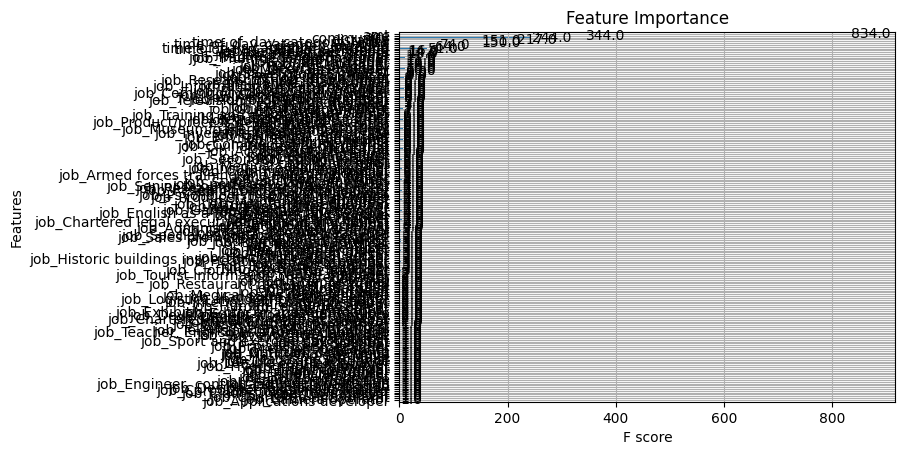

In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=[ 'time_of_day_category', 'job'])
features = ['gender_encoded', 'community']
for col in features:
    X_encoded[col] = X_encoded[col].astype('int')
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost model
model = xgb.XGBClassifier(random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1')

print(f"Cross-Validation F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean()}")

# Train the model on the balanced training data
model.fit(X_train_balanced, y_train_balanced)

# Predict on the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model
print(f"Classification Report:\n{classification_report(y_val, y_val_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_val_pred)}")

# Plot feature importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()


Cross-Validation F1 Scores: [0.62474645 0.59109312 0.57142857 0.63326653 0.59381443]
Mean F1 Score: 0.6028698210395123
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64540
           1       0.80      0.51      0.62       360

    accuracy                           1.00     64900
   macro avg       0.90      0.76      0.81     64900
weighted avg       1.00      1.00      1.00     64900

Confusion Matrix:
[[64493    47]
 [  175   185]]


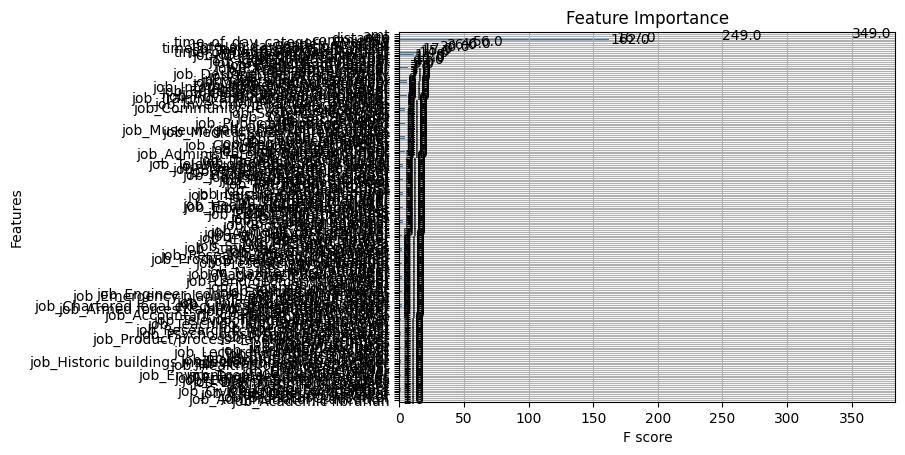

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=['time_of_day_category', 'job'])
features = ['gender_encoded', 'community']
for col in features:
    X_encoded[col] = X_encoded[col].astype('int')

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = xgb.XGBClassifier(random_state=42,enable_categorical=True)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

print(f"Cross-Validation F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean()}")

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model
print(f"Classification Report:\n{classification_report(y_val, y_val_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_val_pred)}")

# Plot feature importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


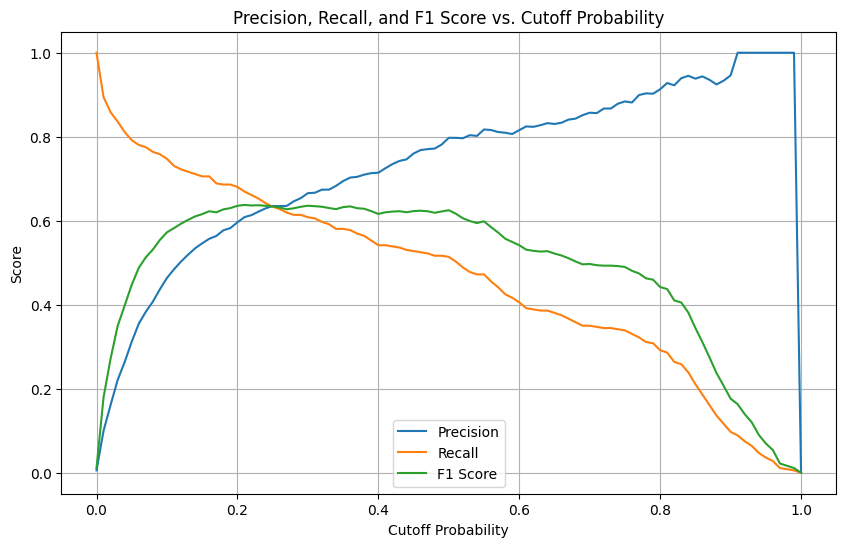

Best cutoff for F1 Score: 0.21
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64540
           1       0.61      0.67      0.64       360

    accuracy                           1.00     64900
   macro avg       0.80      0.83      0.82     64900
weighted avg       1.00      1.00      1.00     64900



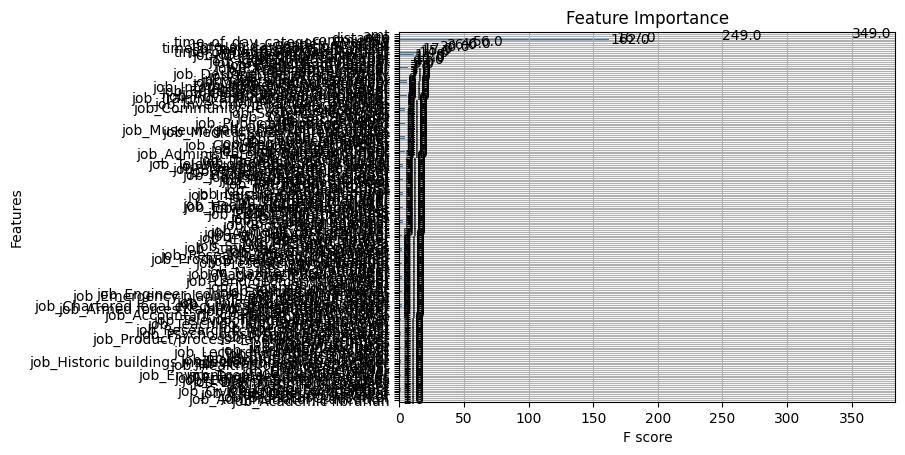

In [41]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score

y_val_pred_proba = model.predict_proba(X_val)[:, 1]
cutoffs = np.linspace(0, 1, 101)
precision = []
recall = []
f1 = []

for cutoff in cutoffs:
    y_val_pred = (y_val_pred_proba >= cutoff).astype(int)
    precision.append(precision_score(y_val, y_val_pred))
    recall.append(recall_score(y_val, y_val_pred))
    f1.append(f1_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, precision, label='Precision')
plt.plot(cutoffs, recall, label='Recall')
plt.plot(cutoffs, f1, label='F1 Score')
plt.xlabel('Cutoff Probability')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Cutoff Probability')
plt.legend()
plt.grid(True)
plt.show()


best_cutoff = cutoffs[np.argmax(f1)]
print(f"Best cutoff for F1 Score: {best_cutoff}")

y_val_pred = (y_val_pred_proba >= best_cutoff).astype(int)
print(classification_report(y_val,y_val_pred))


xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

In [42]:
test_df = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

In [43]:
test_df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [44]:
TransE_model=result

In [45]:
import networkx as nx
from community import community_louvain
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'])
test_df['time_of_day'] = (test_df['trans_date_trans_time'].dt.hour * 60) + test_df['trans_date_trans_time'].dt.minute
test_df['time_of_day_category'] = pd.cut(test_df['time_of_day'], bins=[0, 6*60, 12*60, 18*60, 24*60], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
test_df['unix_time_c'] = pd.to_datetime(test_df['unix_time'], unit='s')
test_df['time_of_day_uc'] = (test_df['unix_time_c'].dt.hour * 60) + test_df['unix_time_c'].dt.minute
test_df['time_of_day_category_uc'] = pd.cut(test_df['time_of_day_uc'], bins=[0, 6*60, 12*60, 18*60, 24*60], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

test_df = test_df.drop(['Unnamed: 0', 'trans_date_trans_time','trans_num', 'unix_time'],axis=1)
test_df['distance']= (test_df['lat'] - test_df['merch_lat'])**2 + (test_df['long'] - test_df['merch_long'])**2
#test_df['merchant'] = test_df['merchant'].apply(clean_text)
#test_df['category'] = test_df['category'].apply(clean_text)
test_df['city_state'] = test_df['city'] + '_' + test_df['state']
test_df = test_df.dropna(subset=['dob'])
test_df['age'] = test_df['dob'].apply(calculate_age)

categorical_cols = ['category', 'gender', 'job','city','state','merchant','street','city_state']
for col in categorical_cols:
    test_df[col] = test_df[col].astype('category')

test_df.drop(['merch_lat', 'merch_long','lat', 'long','street','zip','city_pop','dob'],axis=1,inplace=True)


# Create graph for test data
G_test = nx.Graph()
for index, row in test_df.iterrows():
    trans_id = f'trans_{index}'
    G_test.add_node(trans_id, label='transaction')
    G_test.add_node(row['merchant'], label='merchant')
    G_test.add_node(row['category'], label='category')
    G_test.add_node(row['city'], label='city')
    G_test.add_node(row['state'], label='state')
    G_test.add_edge(trans_id, row['merchant'], relationship='made_at')
    G_test.add_edge(trans_id, row['category'], relationship='belongs_to')
    G_test.add_edge(trans_id, row['city'], relationship='located_in')
    G_test.add_edge(trans_id, row['state'], relationship='in')
    G_test.add_node(row['time_of_day_category'], label='time')
    G_test.add_edge(trans_id, row['time_of_day_category'], relationship='time')
    #G_test.add_node(row['cc_num'], label='cc_num')
    #G_test.add_edge(trans_id, row['cc_num'], relationship='card')
    G_test.add_node(row['job'], label='job')
    G_test.add_edge(trans_id, row['job'], relationship='job')
# Community detection for test data
partition_test = community_louvain.best_partition(G_test)
test_df['community'] = test_df.index.map(lambda x: partition_test.get(f'trans_{x}', -1))

# Label Propagation for test data (using the trained model)
transaction_nodes_test = [node for node in G_test.nodes() if str(node).startswith('trans_')]
#graph_laplacian_test = nx.laplacian_matrix(G_test, nodelist=transaction_nodes_test).toarray()
#predicted_labels_test = label_prop_model.predict(graph_laplacian_test) # Use the trained model here
#test_df['predicted_labels'] = predicted_labels_test


In [46]:
from pykeen.triples.utils import get_entities
entity_to_id = TransE_model.training.entity_to_id

# Create triples for the test data
test_triples = []
for index, row in test_df.iterrows():
    trans_id = f'trans_{index}'
    test_triples.append((trans_id, 'made_at', row['merchant']))
    test_triples.append((trans_id, 'belongs_to', row['category']))
    test_triples.append((trans_id, 'located_in', row['city']))
    test_triples.append((trans_id, 'in', row['state']))
    test_triples.append((trans_id, 'in', row['time_of_day_category']))
    test_triples.append((trans_id, 'job', row['job']))
    #test_triples.append((trans_id, 'card', row['cc_num']))
test_triples = np.array(test_triples)

# Remove malformed entries (if any)
valid_test_triples = [triple for triple in test_triples if len(triple) == 3 and all(isinstance(item, str) for item in triple)]
test_triples = np.array(valid_test_triples)


# Create a TriplesFactory for the test data, handling unknown entities
test_tf = TriplesFactory.from_labeled_triples(
    triples=test_triples,
    entity_to_id=entity_to_id,  # Use the entity to ID mapping from training
    relation_to_id=TransE_model.training.relation_to_id,  # Use relation mapping from training
    create_inverse_triples=False, # Assuming you don't need inverse triples
)



In [47]:

# Get entity embeddings for the test data
# Get all entity IDs present in the test data
all_test_entity_ids = set(test_tf.entities_to_ids(get_entities(test_tf.mapped_triples))) # Instead of test_tf.get_entities()

# Filter entity embeddings for entities present in test data
test_entity_indices = torch.tensor([test_tf.entity_to_id[entity] for entity in test_tf.entity_to_id if test_tf.entity_to_id[entity] in all_test_entity_ids], device=TransE_model.model.device)
test_embeddings = TransE_model.model.entity_representations[0](indices=test_entity_indices).cpu().detach().numpy()

# Create a DataFrame with embeddings for the test data, using filtered entity IDs
test_embedding_df = pd.DataFrame(test_embeddings, index=test_entity_indices.cpu().numpy())

# Merge embeddings with the test DataFrame, using numeric entity IDs
test_df['embedding'] = test_df.index.map(lambda x: test_embedding_df.loc[test_tf.entity_to_id.get(f'trans_{x}')].values if test_tf.entity_to_id.get(f'trans_{x}') is not None else None)

In [48]:
test_df['gender_encoded'] = le.transform(test_df['gender'])

In [49]:
test_df.to_csv("test_df_new.csv")

In [50]:
test_df_trim=test_df[['amt', 'distance', 'age', 'gender_encoded', 'community', 'time_of_day_category', 'job']]
test_df_encoded = pd.get_dummies(test_df_trim, columns=['time_of_day_category', 'job'])
for col in features:
    test_df_encoded[col] = test_df_encoded[col].astype('int')

missing_cols = set(X_train.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0

test_df_encoded = test_df_encoded[X_train.columns]


X_test = test_df_encoded
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= best_cutoff).astype(int) # Use the best cutoff from training

# Evaluate the model on the test data
print(classification_report(test_df['is_fraud'], y_test_pred)) # Assuming 'is_fraud' column exists in test_df
print(confusion_matrix(test_df['is_fraud'], y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.46      0.56      0.51      2145

    accuracy                           1.00    555719
   macro avg       0.73      0.78      0.75    555719
weighted avg       1.00      1.00      1.00    555719

[[552193   1381]
 [   948   1197]]


##### Use stacking

In [51]:
!pip install scikit-learn==1.2.2
!pip install xgboost==1.7.5
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression



base_learners = [
    ('rf',RandomForestClassifier(n_estimators=100)),
    ('xgb', xgb.XGBClassifier(random_state=42, enable_categorical=True))
]

meta_learner = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 8.5 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

In [52]:
#model = xgb.XGBClassifier(early_stopping_rounds=10, eval_metric='auc',enable_categorical=True)
#model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Make predictions on the validation set
y_val_pred = stacking_model.predict(X_val)

print(f"classification report \n {classification_report(y_val, y_val_pred)}")
print(f"confusion_matrix \n {confusion_matrix(y_val, y_val_pred)}")


classification report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     64540
           1       0.80      0.53      0.64       360

    accuracy                           1.00     64900
   macro avg       0.90      0.77      0.82     64900
weighted avg       1.00      1.00      1.00     64900

confusion_matrix 
 [[64491    49]
 [  168   192]]


In [53]:
y_pred = stacking_model.predict(X_test)
y_test=test_df['is_fraud']
print(f"classification report \n {classification_report(y_test, y_pred)}")
print(f"confusion_matrix \n {confusion_matrix(y_test, y_pred)}")

classification report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.43      0.54      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.71      0.77    555719
weighted avg       1.00      1.00      1.00    555719

confusion_matrix 
 [[553230    344]
 [  1230    915]]


In [64]:
# Install LIME
#!pip install lime

import lime
import lime.lime_tabular
import numpy as np

# Assuming you have a trained stacking classifier named 'stacking_clf'
# and your training data is in 'X_train' and 'y_train'

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

# Select an instance to explain
instance_idx = 2000
instance = X_train.iloc[instance_idx]

# Generate explanation
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=stacking_model.predict_proba
)

# Display explanation
exp.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

[0]	validation_0-auc:0.96543
[1]	validation_0-auc:0.96552
[2]	validation_0-auc:0.96882
[3]	validation_0-auc:0.97119
[4]	validation_0-auc:0.97228
[5]	validation_0-auc:0.97265
[6]	validation_0-auc:0.97311
[7]	validation_0-auc:0.97397
[8]	validation_0-auc:0.97459
[9]	validation_0-auc:0.97334
[10]	validation_0-auc:0.97368
[11]	validation_0-auc:0.97392
[12]	validation_0-auc:0.97533
[13]	validation_0-auc:0.97541
[14]	validation_0-auc:0.97520
[15]	validation_0-auc:0.97537
[16]	validation_0-auc:0.97544
[17]	validation_0-auc:0.97550
[18]	validation_0-auc:0.97545
[19]	validation_0-auc:0.97566
[20]	validation_0-auc:0.97510
[21]	validation_0-auc:0.97525
[22]	validation_0-auc:0.97524
[23]	validation_0-auc:0.97532
classification report 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     64540
           1       0.09      0.89      0.16       360

    accuracy                           0.95     64900
   macro avg       0.54      0.92      0.57     

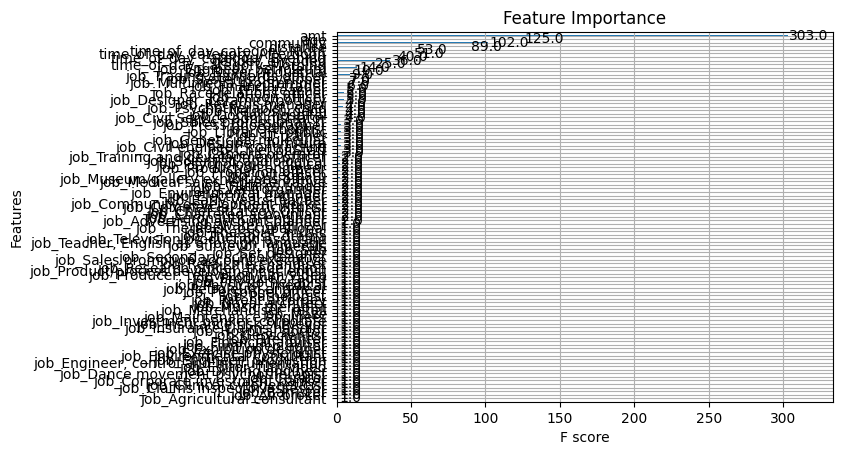

In [55]:
scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = xgb.XGBClassifier(early_stopping_rounds =5 ,eval_metric='auc', random_state=42,enable_categorical=True,scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train,eval_set=[(X_val, y_val)])

y_val_pred = model.predict(X_val)


print(f"classification report \n {classification_report(y_val, y_val_pred)}")
print(f"confusion_matrix \n {confusion_matrix(y_val, y_val_pred)}")

xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()


In [56]:

df_majority = train_df[train_df.is_fraud==0]
df_minority = train_df[train_df.is_fraud==1]

# Upsample minority class
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=int(0.05*len(train_df)),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
train_df_upsampled.is_fraud.value_counts()



is_fraud
0    322592
1     16224
Name: count, dtype: int64

classification report 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     64547
           1       0.93      0.84      0.88      3217

    accuracy                           0.99     67764
   macro avg       0.96      0.92      0.94     67764
weighted avg       0.99      0.99      0.99     67764

confusion_matrix 
 [[64331   216]
 [  518  2699]]


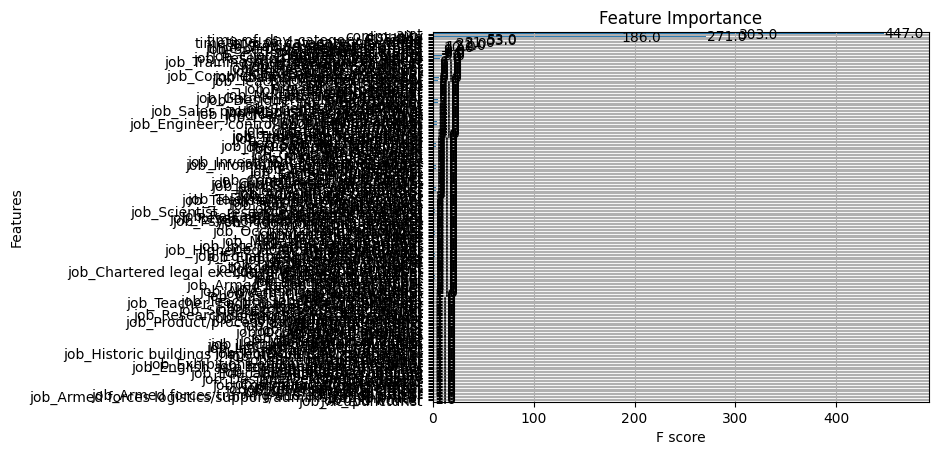

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


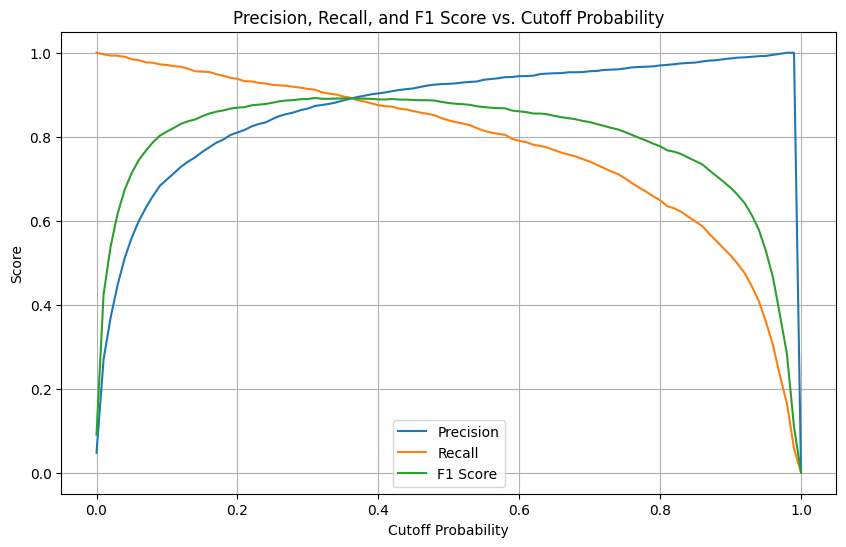

Best cutoff for F1 Score: 0.31
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     64547
           1       0.87      0.91      0.89      3217

    accuracy                           0.99     67764
   macro avg       0.93      0.95      0.94     67764
weighted avg       0.99      0.99      0.99     67764



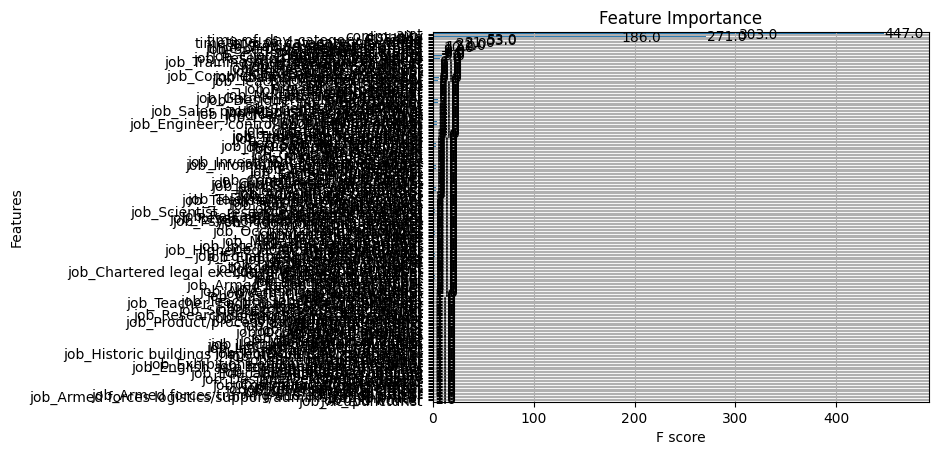

Testing

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.26      0.62      0.37      2145

    accuracy                           0.99    555719
   macro avg       0.63      0.81      0.68    555719
weighted avg       1.00      0.99      0.99    555719

[[549757   3817]
 [   808   1337]]


In [57]:

le = LabelEncoder()
train_df_upsampled['gender_encoded'] = le.fit_transform(train_df_upsampled['gender'])

X =  train_df_upsampled[['amt', 'distance', 'age', 'gender_encoded','community','time_of_day_category','job']]
y = train_df_upsampled['is_fraud']
X_encoded = pd.get_dummies(X, columns=['time_of_day_category', 'job'])
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(random_state=42, enable_categorical=True)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

print(f"classification report \n {classification_report(y_val, y_val_pred)}")
print(f"confusion_matrix \n {confusion_matrix(y_val, y_val_pred)}")

xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

y_val_pred_proba = model.predict_proba(X_val)[:, 1]
cutoffs = np.linspace(0, 1, 101)
precision = []
recall = []
f1 = []

for cutoff in cutoffs:
    y_val_pred = (y_val_pred_proba >= cutoff).astype(int)
    precision.append(precision_score(y_val, y_val_pred))
    recall.append(recall_score(y_val, y_val_pred))
    f1.append(f1_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, precision, label='Precision')
plt.plot(cutoffs, recall, label='Recall')
plt.plot(cutoffs, f1, label='F1 Score')
plt.xlabel('Cutoff Probability')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Cutoff Probability')
plt.legend()
plt.grid(True)
plt.show()

best_cutoff = cutoffs[np.argmax(f1)]
print(f"Best cutoff for F1 Score: {best_cutoff}")

y_val_pred = (y_val_pred_proba >= best_cutoff).astype(int)
print(classification_report(y_val,y_val_pred))

xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

print("Testing\n")
test_df_trim=test_df[['amt', 'distance', 'age', 'gender_encoded', 'community', 'time_of_day_category', 'job']]
test_df_encoded = pd.get_dummies(test_df_trim, columns=['time_of_day_category', 'job'])

missing_cols = set(X_train.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0

test_df_encoded = test_df_encoded[X_train.columns]


X_test = test_df_encoded
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= best_cutoff).astype(int) # Use the best cutoff from training

# Evaluate the model on the test data
print(classification_report(test_df['is_fraud'], y_test_pred)) # Assuming 'is_fraud' column exists in test_df
print(confusion_matrix(test_df['is_fraud'], y_test_pred))

In [67]:
import torch
from pykeen.models import TransE
from pykeen.triples import TriplesFactory

# Initialize the model with the same parameters used during training
model = TransE(
    embedding_dim=50,  # Ensure this matches the embedding dimension used during training
    num_entities=train_tf.num_entities,
    num_relations=train_tf.num_relations,
)

# Load the saved state dictionary
model.load_state_dict(torch.load('transe_model.pt'))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Example: Get embeddings for a specific entity
entity_id = train_tf.entity_to_id['trans_0']  # Replace 'trans_0' with your entity ID
entity_embedding = model.entity_representations[0].cpu().detach().numpy()

print(entity_embedding)


TypeError: ERModel.__init__() missing 1 required keyword-only argument: 'triples_factory'